7/5/2019

Generating close, split, and far conditions for each of the games in the train/dev/test data.

To generate colors, we use rejection sampling. We choose a color as our target. Then we sample distractor colors in RGB space and calculate the distance between each color and the target. Depending on the condition that the target is a part of, we keep the number of sampled colors close to and far from the target to construct the remaining two conditions.

In [1]:
# so we can access classes from parent directory
import sys
sys.path.append("..")

In [27]:
from monroe_data import MonroeData, MonroeDataEntry, Color # for loading in training data
from evaluation import delta_e_dist

In [8]:
import numpy as np
import copy                   # for deepcopy
import random                 # for randrange
import matplotlib.pyplot as plt
%matplotlib inline

In [113]:
train_data = MonroeData("../data/csv/train_corpus_monroe.csv", "../data/entries/train_entries_monroe.pkl")
dev_data = MonroeData("../data/csv/dev_corpus_monroe.csv", "../data/entries/dev_entries_monroe.pkl")

In [114]:
train_data_small = train_data[:10]

In [45]:
COLOR_DIST_THRESHOLD   = 20 # from Monroe et al., 2017
COLOR_DIST_LOWER_BOUND = 5  # from Monroe et al., 2017

In [296]:
def sample_rgb():
    return [random.randrange(256) for _ in range(3)]

def sample_rgb_norm():
    return np.array(sample_rgb()) / 256

def sample_rgb_discrete(chunks=32):
    rgb_vals = np.arange(1, chunks)*(256/chunks) # don't choose 0 or chunks
    return [random.choice(rgb_vals) for  _ in range(3)]

def sample_rgb_discrete_norm(chunks=32):
    return np.array(sample_rgb_discrete(chunks)) / 256


In [162]:
def calculate_color_distance(color1, color2):
    """
    Calcuates the CIEDE-2000 delta-e distance between two monroe_data.Color objects
    """
    return delta_e_dist(np.array(color1.rgb_norm), np.array(color2.rgb_norm))

In [430]:
def sample_color(close=[], far=[]):
    """
    Sample color close to and far from given colors using rejection sampling
    
    Args:
        close: list of colors the sampled color should be close to
        far: list of colors the sampled color should be far from
        
    Returns:
        returns a Color (monroe_data.Color object) containing sampled color
    """
    num_rejections = 0
    while True:
        candidate_rgb = np.array(sample_rgb_norm())
        
        close_distances = np.array([delta_e_dist(candidate_rgb, np.array(close_color.rgb_norm)) for close_color in close])
        far_distances = np.array([delta_e_dist(candidate_rgb, np.array(far_color.rgb_norm)) for far_color in far])
        
        # Check that candidate color respects distance constraints given by close and far
        # Note: all([]) => True
        candidate_passes = all(close_distances > COLOR_DIST_LOWER_BOUND)
        candidate_passes = candidate_passes and all(close_distances < COLOR_DIST_THRESHOLD)
        candidate_passes = candidate_passes and all(far_distances > COLOR_DIST_THRESHOLD)
        
        if candidate_passes:
            candidate_color = Color(*(256 * candidate_rgb), space="rgb")
            #print(num_rejections)
            return candidate_color
        num_rejections += 1
        if num_rejections > 10000:
            print("Mistake after rejection", num_rejections, close, far, 256*candidate_rgb)
            return Color(*(256 * candidate_rgb), space="rgb")


        
    
    

In [42]:
ciede_scores = [calculate_color_distance(Color(*sample_rgb(), "rgb"), Color(*sample_rgb(), "rgb")) for _ in range(1000)]

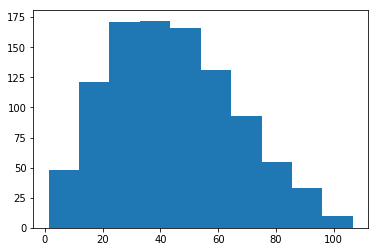

In [43]:
plt.hist(ciede_scores)
plt.show()

In [188]:
import time

In [190]:
save_time = time.time()

In [193]:
time.time() - save_time

16.223710775375366

In [456]:
def generate_other_condition_entries(data, num_samples=1):
    """
    Creates new data entries that place the target in other conditions.
    
    Given a MonroeData object, samples colors to c
    
    Args:
        data: the monroe_data.MonroeData object to draw the entries from.
        num_samples: how many new entries to generate for each condition.
            Default value is 1.
            
    Returns:
        A list containing all the original and generated data entries. 
    """
    all_condition_prediction_entries = []
    all_conditions = {"close", "split", "far"}

    start_time = time.time()
    # iterate through data entries
    for i, de in enumerate(data):
        if i%100 == 0:
            print(f"{(time.time() - start_time):.2f}s:\t{(100 * i/len(data)):.2f}% done!")
        target_color = de.colors[0]

        conditions_needed = all_conditions - {de.condition}
        generated_colors = []
        
        for _ in range(num_samples):
            # generate the colors for the conditions we need
            if "close" in conditions_needed:
                dist1 = sample_color(close=[target_color])
                dist2 = sample_color(close=[target_color, dist1])
                generated_colors.append(("close", [dist1, dist2]))

            if "split" in conditions_needed:
                dist1 = sample_color(close=[target_color])
                dist2 = sample_color(far=[target_color, dist1])
                generated_colors.append(("split", [dist1, dist2]))

            if "far" in conditions_needed:
                dist1 = sample_color(far=[target_color])
                dist2 = sample_color(far=[target_color, dist1])
                generated_colors.append(("far", [dist1, dist2]))

        # add all conditions to new data entries and add data entries to master list
        # add first entry
        all_condition_prediction_entries.append(copy.deepcopy(de))
        
        # add generated colors
        for condition, distractors in generated_colors:
            new_entry = copy.deepcopy(de)
            new_entry.colors = [target_color, *distractors]
            new_entry.condition = condition
            all_condition_prediction_entries.append(new_entry)
            
    return all_condition_prediction_entries


In [484]:
%%time
train_data_50samples = generate_other_condition_entries(train_data, num_samples=50)

0.00s:	0.00% done!
102.97s:	0.64% done!
199.07s:	1.28% done!
293.38s:	1.92% done!
393.78s:	2.55% done!
494.01s:	3.19% done!
594.04s:	3.83% done!
683.61s:	4.47% done!
771.85s:	5.11% done!
867.88s:	5.75% done!
952.70s:	6.38% done!
1055.66s:	7.02% done!
1152.90s:	7.66% done!
1246.91s:	8.30% done!
1346.07s:	8.94% done!
1441.40s:	9.58% done!
1536.35s:	10.21% done!
1634.78s:	10.85% done!
1732.32s:	11.49% done!
1828.85s:	12.13% done!
1919.84s:	12.77% done!
2008.31s:	13.41% done!
2096.83s:	14.04% done!
2183.01s:	14.68% done!
2270.57s:	15.32% done!
2365.74s:	15.96% done!
2456.10s:	16.60% done!
2559.33s:	17.24% done!
2648.44s:	17.87% done!
2738.20s:	18.51% done!
2826.38s:	19.15% done!
2917.34s:	19.79% done!
3008.82s:	20.43% done!
3106.83s:	21.07% done!
3210.01s:	21.70% done!
3300.59s:	22.34% done!
3400.39s:	22.98% done!
3493.53s:	23.62% done!
3584.59s:	24.26% done!
3684.07s:	24.90% done!
3775.05s:	25.53% done!
3879.86s:	26.17% done!
3980.30s:	26.81% done!
4075.14s:	27.45% done!
4175.94s:	28.09% 

In [486]:
len(train_data_50samples)

1582165

In [488]:
len(train_data) + len(train_data)*100

1582165

22 close
Medium pink ~ the medium dark one


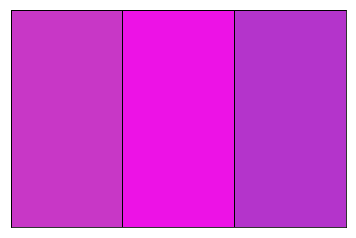

23 split
Medium pink ~ the medium dark one


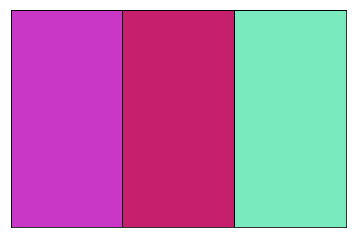

24 far
Medium pink ~ the medium dark one


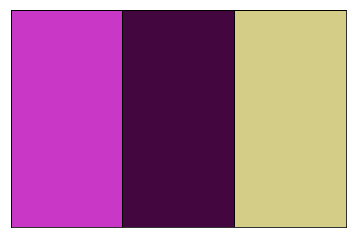

25 split
Medium pink ~ the medium dark one


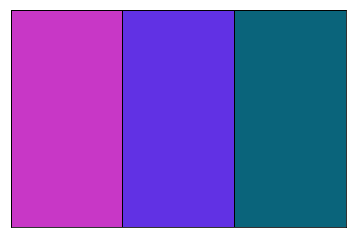

26 far
Medium pink ~ the medium dark one


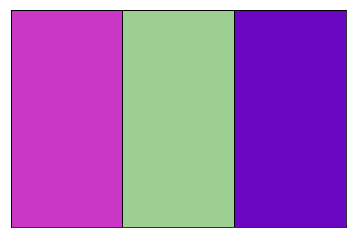

27 split
Medium pink ~ the medium dark one


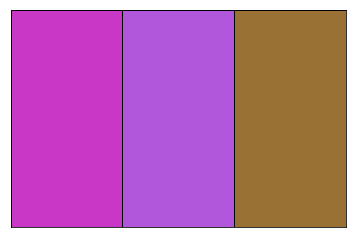

28 far
Medium pink ~ the medium dark one


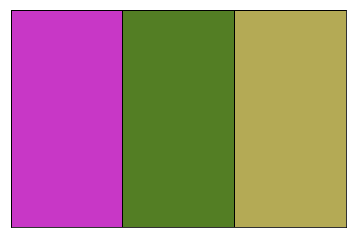

29 split
Medium pink ~ the medium dark one


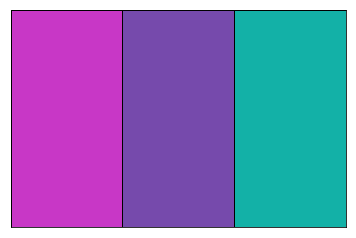

30 far
Medium pink ~ the medium dark one


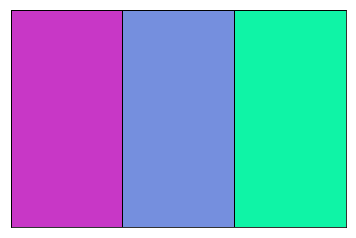

31 split
Medium pink ~ the medium dark one


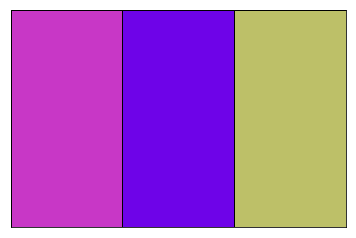

32 far
Medium pink ~ the medium dark one


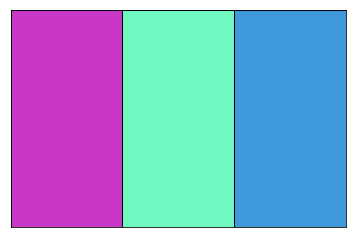

In [462]:
for i in range(22, 33):
    print(i, x[i].condition)
    train_data.display_custom_game(x[i].colors, x[i].caption)

In [468]:
def distance_checks(entries, num_samples=1):
    """
    Checks that all of the distances between colors are correct for the condition.
    
    Args:
        entries: list of generated monroe_data.MonroeDataEntrys
        num_samples: number of samples generated for each condition. Default 1
        
    Returns:
        Tuple of distances between distractors, distance between target and the first distractor,
        distance between target and the second distractor
    """
    # get the pairwise distances
    distractor_distances = [(de.condition, calculate_color_distance(de.colors[1], de.colors[2])) for de in entries]
    target_dist1_distances = [(de.condition, calculate_color_distance(de.colors[0], de.colors[1])) for de in entries]
    target_dist2_distances = [(de.condition, calculate_color_distance(de.colors[0], de.colors[2])) for de in entries]

    # set up testing
    test_failure_str = "FAILURE. Test: {}\tCondition: {}\t Entry at index {} with distance {}"
    empirical_data_freq = 2*num_samples + 1 # frequency of emperical (i.e. not generated data) in the entries list
    
    # check that distractors are the right distance apart
    testname = "Distractor Distance Test"
    for i, cd in enumerate(distractor_distances):
        if i % empirical_data_freq == 0: continue
        condition, distance = cd
        if condition == "close" and distance > COLOR_DIST_THRESHOLD:
            print(test_failure_str.format(testname, condition, i, distance))
        elif condition == "far" and distance < COLOR_DIST_THRESHOLD:
            print(test_failure_str.format(testname, condition, i, distance))
        elif condition == "split" and distance < COLOR_DIST_THRESHOLD:
            print(test_failure_str.format(testname, condition, i, distance))

    testname = "Target-Distractor 1 Distance Test (Close/Far Condition)"
    for i, cd in enumerate(target_dist1_distances):
        if i % empirical_data_freq == 0: continue
        condition, distance = cd
        if condition == "close" and distance > COLOR_DIST_THRESHOLD:
            print(test_failure_str.format(testname, condition, i, distance))
        elif condition == "far" and distance < COLOR_DIST_THRESHOLD:
            print(test_failure_str.format(testname, condition, i, distance))

    testname = "Target-Distractor 2 Distance Test (Close/Far Condition)"
    for i, cd in enumerate(target_dist2_distances):
        if i % empirical_data_freq == 0: continue
        condition, distance = cd
        if condition == "close" and distance > COLOR_DIST_THRESHOLD:
            print(test_failure_str.format(testname, condition, i, distance))
        elif condition == "far" and distance < COLOR_DIST_THRESHOLD:
            print(test_failure_str.format(testname, condition, i, distance))
    
    testname = "Target-Distractor Distance Test (Split Condition)"
    for i in range(len(target_dist1_distances)):
        if i % empirical_data_freq == 0: continue
        if target_dist1_distances[i][0] == "split":
            if (target_dist1_distances[i][1] > COLOR_DIST_THRESHOLD and\
            target_dist2_distances[i][1] < COLOR_DIST_THRESHOLD) or (target_dist1_distances[i][1] < COLOR_DIST_THRESHOLD and\
            target_dist2_distances[i][1] > COLOR_DIST_THRESHOLD):
                continue
            else:
                print(test_failure_str.format(testname, condition, i, distance))
                
    return distractor_distances, target_dist1_distances, target_dist2_distances
    

In [489]:
%%time
dd, td1, td2 = distance_checks(train_data_50samples, num_samples=50)

In [501]:
# turn the entry list into a dataframe - no fields are reliable other than color and caption :(
def entries_to_dataframe(data, entries, distractor_distances, target_dist1_distances,
                         target_dist2_distances, num_samples=1):
    """
    Converts entries list to pandas dataframe in the style of Monroe et. al, 2017
    
    Duplicates rows from the original data and replaces the colors, the condition,
    and the color distances with the ones from the generated data. In the generated
    dataframe, only the color, caption and color distances are reliable.
    
    Args:
        data: monroe_data.MonroeData object that stores the original entries and dataframe
        entries: list of monroe_data.MonroeDataEntry objects that contains both original 
            and generated data
        distractor_distances: list of tuples ("condition", distance) with the distance
            between distractor colors
        target_dist1_distances: Same as distractor_distances, but with distance between
            target and first distractor
        target_dist2_distances: Same as distractor_distances, but with distance between
            target and second distractor
        num_samples: number of samples that were generated for each data entry for each condition.
            Default 1.
            
    """
    
    condition_prediction_df = pd.DataFrame(index=list(range(len(entries))), columns=data.data.columns)
    empirical_data_freq = 2*num_samples + 1
    
    start_time = time.time()
    for round_num, de in enumerate(entries):
        if round_num % 100 == 0:
            print(f"{(time.time() - start_time):.2f}s:\t{(100 * round_num/len(entries)):.2f}% done!")

        condition_prediction_df.loc[round_num] = data.data.loc[round_num // empirical_data_freq]
        condition_prediction_df.loc[round_num, "gameid"] = "{}_{}".format(
            condition_prediction_df.loc[round_num, "gameid"], round_num % empirical_data_freq)
        condition_prediction_df.loc[round_num, "condition"] = de.condition

        # update the distractor colors and distances if entry isn't first in its group
        if round_num % empirical_data_freq != 0:
            dist1h, dist1s, dist1l = de.colors[1].hsl
            dist2h, dist2s, dist2l = de.colors[2].hsl

            # CSV is organized by "click", "alt1", "alt2" rather than "target", "dist1", "dist2"
            # so determine where each generated color maps to.
            dist1_maps_to, dist2_maps_to = None, None
            for label in ["click", "alt1", "alt2"]:
                status = condition_prediction_df.loc[round_num, f"{label}Status"]
                if status == "distr1":
                    dist1_maps_to = label
                elif status == "distr2":
                    dist2_maps_to = label

            # update dataframe with colors
            condition_prediction_df.loc[round_num, f"{dist1_maps_to}ColH"] = dist1h
            condition_prediction_df.loc[round_num, f"{dist1_maps_to}ColS"] = dist1s
            condition_prediction_df.loc[round_num, f"{dist1_maps_to}ColL"] = dist1l

            condition_prediction_df.loc[round_num, f"{dist2_maps_to}ColH"] = dist2h
            condition_prediction_df.loc[round_num, f"{dist2_maps_to}ColS"] = dist2s
            condition_prediction_df.loc[round_num, f"{dist2_maps_to}ColL"] = dist2l

            # update dataframe with color distances
            condition_prediction_df.loc[round_num, f"targetD1Diff"] = int(target_dist1_distances[round_num][1])
            condition_prediction_df.loc[round_num, f"targetD2Diff"] = int(target_dist2_distances[round_num][1])
            condition_prediction_df.loc[round_num, f"D1D2Diff"] = int(distractor_distances[round_num][1])
            
    return condition_prediction_df

In [502]:
train_data_50samples_df = entries_to_dataframe(train_data, train_data_50samples, dd, td1, td2, 50)

0.00s:	0.00% done!
0.21s:	0.01% done!
0.42s:	0.01% done!
0.62s:	0.02% done!
0.84s:	0.03% done!
1.05s:	0.03% done!
1.26s:	0.04% done!
1.46s:	0.04% done!
1.66s:	0.05% done!
1.87s:	0.06% done!
2.07s:	0.06% done!
2.29s:	0.07% done!
2.49s:	0.08% done!
2.70s:	0.08% done!
2.90s:	0.09% done!
3.11s:	0.09% done!
3.31s:	0.10% done!
3.52s:	0.11% done!
3.72s:	0.11% done!
3.93s:	0.12% done!
4.13s:	0.13% done!
4.33s:	0.13% done!
4.53s:	0.14% done!
4.75s:	0.15% done!
4.94s:	0.15% done!
5.15s:	0.16% done!
5.35s:	0.16% done!
5.56s:	0.17% done!
5.75s:	0.18% done!
5.96s:	0.18% done!
6.17s:	0.19% done!
6.38s:	0.20% done!
6.58s:	0.20% done!
6.78s:	0.21% done!
6.98s:	0.21% done!
7.20s:	0.22% done!
7.41s:	0.23% done!
7.61s:	0.23% done!
7.82s:	0.24% done!
8.02s:	0.25% done!
8.23s:	0.25% done!
8.44s:	0.26% done!
8.67s:	0.27% done!
8.88s:	0.27% done!
9.11s:	0.28% done!
9.31s:	0.28% done!
9.53s:	0.29% done!
9.73s:	0.30% done!
9.95s:	0.30% done!
10.17s:	0.31% done!
10.37s:	0.32% done!
10.58s:	0.32% done!
10.78s:	0

89.10s:	2.61% done!
89.32s:	2.62% done!
89.53s:	2.62% done!
89.74s:	2.63% done!
89.94s:	2.64% done!
90.16s:	2.64% done!
90.37s:	2.65% done!
90.58s:	2.65% done!
90.78s:	2.66% done!
90.98s:	2.67% done!
91.19s:	2.67% done!
91.39s:	2.68% done!
91.59s:	2.69% done!
91.81s:	2.69% done!
92.01s:	2.70% done!
92.22s:	2.71% done!
92.43s:	2.71% done!
92.63s:	2.72% done!
92.84s:	2.72% done!
93.04s:	2.73% done!
93.24s:	2.74% done!
93.44s:	2.74% done!
93.64s:	2.75% done!
93.84s:	2.76% done!
94.04s:	2.76% done!
94.25s:	2.77% done!
94.45s:	2.77% done!
94.67s:	2.78% done!
94.87s:	2.79% done!
95.09s:	2.79% done!
95.29s:	2.80% done!
95.50s:	2.81% done!
95.70s:	2.81% done!
95.91s:	2.82% done!
96.11s:	2.83% done!
96.31s:	2.83% done!
96.51s:	2.84% done!
96.71s:	2.84% done!
96.92s:	2.85% done!
97.13s:	2.86% done!
97.33s:	2.86% done!
97.54s:	2.87% done!
97.74s:	2.88% done!
97.95s:	2.88% done!
98.15s:	2.89% done!
98.36s:	2.89% done!
98.56s:	2.90% done!
98.77s:	2.91% done!
98.97s:	2.91% done!
99.18s:	2.92% done!


171.92s:	5.09% done!
172.13s:	5.10% done!
172.34s:	5.11% done!
172.55s:	5.11% done!
172.77s:	5.12% done!
172.97s:	5.13% done!
173.18s:	5.13% done!
173.38s:	5.14% done!
173.59s:	5.14% done!
173.80s:	5.15% done!
174.01s:	5.16% done!
174.22s:	5.16% done!
174.43s:	5.17% done!
174.66s:	5.18% done!
174.92s:	5.18% done!
175.18s:	5.19% done!
175.40s:	5.20% done!
175.61s:	5.20% done!
175.82s:	5.21% done!
176.03s:	5.21% done!
176.25s:	5.22% done!
176.45s:	5.23% done!
176.68s:	5.23% done!
176.89s:	5.24% done!
177.11s:	5.25% done!
177.32s:	5.25% done!
177.53s:	5.26% done!
177.76s:	5.26% done!
177.96s:	5.27% done!
178.18s:	5.28% done!
178.41s:	5.28% done!
178.62s:	5.29% done!
178.85s:	5.30% done!
179.07s:	5.30% done!
179.28s:	5.31% done!
179.51s:	5.32% done!
179.76s:	5.32% done!
180.04s:	5.33% done!
180.27s:	5.33% done!
180.50s:	5.34% done!
180.71s:	5.35% done!
180.92s:	5.35% done!
181.13s:	5.36% done!
181.33s:	5.37% done!
181.54s:	5.37% done!
181.75s:	5.38% done!
181.97s:	5.39% done!
182.18s:	5.39

253.45s:	7.57% done!
253.67s:	7.57% done!
253.88s:	7.58% done!
254.11s:	7.58% done!
254.31s:	7.59% done!
254.52s:	7.60% done!
254.73s:	7.60% done!
254.94s:	7.61% done!
255.16s:	7.62% done!
255.37s:	7.62% done!
255.57s:	7.63% done!
255.77s:	7.64% done!
255.98s:	7.64% done!
256.18s:	7.65% done!
256.38s:	7.65% done!
256.59s:	7.66% done!
256.80s:	7.67% done!
257.00s:	7.67% done!
257.19s:	7.68% done!
257.41s:	7.69% done!
257.61s:	7.69% done!
257.82s:	7.70% done!
258.02s:	7.70% done!
258.23s:	7.71% done!
258.43s:	7.72% done!
258.64s:	7.72% done!
258.85s:	7.73% done!
259.07s:	7.74% done!
259.27s:	7.74% done!
259.48s:	7.75% done!
259.68s:	7.76% done!
259.89s:	7.76% done!
260.09s:	7.77% done!
260.29s:	7.77% done!
260.49s:	7.78% done!
260.71s:	7.79% done!
260.90s:	7.79% done!
261.11s:	7.80% done!
261.31s:	7.81% done!
261.51s:	7.81% done!
261.71s:	7.82% done!
261.92s:	7.82% done!
262.11s:	7.83% done!
262.33s:	7.84% done!
262.53s:	7.84% done!
262.73s:	7.85% done!
262.93s:	7.86% done!
263.13s:	7.86

333.66s:	10.04% done!
333.86s:	10.04% done!
334.07s:	10.05% done!
334.27s:	10.06% done!
334.47s:	10.06% done!
334.67s:	10.07% done!
334.87s:	10.07% done!
335.07s:	10.08% done!
335.29s:	10.09% done!
335.49s:	10.09% done!
335.69s:	10.10% done!
335.89s:	10.11% done!
336.10s:	10.11% done!
336.29s:	10.12% done!
336.50s:	10.13% done!
336.70s:	10.13% done!
336.91s:	10.14% done!
337.10s:	10.14% done!
337.31s:	10.15% done!
337.51s:	10.16% done!
337.72s:	10.16% done!
337.92s:	10.17% done!
338.12s:	10.18% done!
338.32s:	10.18% done!
338.53s:	10.19% done!
338.72s:	10.19% done!
338.93s:	10.20% done!
339.12s:	10.21% done!
339.33s:	10.21% done!
339.53s:	10.22% done!
339.73s:	10.23% done!
339.93s:	10.23% done!
340.13s:	10.24% done!
340.33s:	10.25% done!
340.53s:	10.25% done!
340.73s:	10.26% done!
340.94s:	10.26% done!
341.14s:	10.27% done!
341.34s:	10.28% done!
341.54s:	10.28% done!
341.75s:	10.29% done!
341.94s:	10.30% done!
342.15s:	10.30% done!
342.35s:	10.31% done!
342.56s:	10.31% done!
342.76s:	1

409.61s:	12.39% done!
409.80s:	12.40% done!
410.00s:	12.41% done!
410.20s:	12.41% done!
410.40s:	12.42% done!
410.60s:	12.43% done!
410.80s:	12.43% done!
411.00s:	12.44% done!
411.21s:	12.44% done!
411.41s:	12.45% done!
411.62s:	12.46% done!
411.82s:	12.46% done!
412.02s:	12.47% done!
412.22s:	12.48% done!
412.43s:	12.48% done!
412.63s:	12.49% done!
412.84s:	12.50% done!
413.04s:	12.50% done!
413.24s:	12.51% done!
413.44s:	12.51% done!
413.64s:	12.52% done!
413.84s:	12.53% done!
414.05s:	12.53% done!
414.25s:	12.54% done!
414.45s:	12.55% done!
414.65s:	12.55% done!
414.85s:	12.56% done!
415.05s:	12.57% done!
415.28s:	12.57% done!
415.48s:	12.58% done!
415.68s:	12.58% done!
415.88s:	12.59% done!
416.08s:	12.60% done!
416.28s:	12.60% done!
416.49s:	12.61% done!
416.69s:	12.62% done!
416.89s:	12.62% done!
417.09s:	12.63% done!
417.30s:	12.63% done!
417.50s:	12.64% done!
417.70s:	12.65% done!
417.89s:	12.65% done!
418.11s:	12.66% done!
418.31s:	12.67% done!
418.51s:	12.67% done!
418.72s:	1

486.29s:	14.76% done!
486.49s:	14.76% done!
486.70s:	14.77% done!
486.91s:	14.78% done!
487.12s:	14.78% done!
487.32s:	14.79% done!
487.52s:	14.80% done!
487.72s:	14.80% done!
487.93s:	14.81% done!
488.13s:	14.82% done!
488.33s:	14.82% done!
488.53s:	14.83% done!
488.73s:	14.83% done!
488.93s:	14.84% done!
489.14s:	14.85% done!
489.33s:	14.85% done!
489.54s:	14.86% done!
489.73s:	14.87% done!
489.93s:	14.87% done!
490.13s:	14.88% done!
490.33s:	14.88% done!
490.53s:	14.89% done!
490.73s:	14.90% done!
490.94s:	14.90% done!
491.15s:	14.91% done!
491.34s:	14.92% done!
491.55s:	14.92% done!
491.75s:	14.93% done!
491.96s:	14.94% done!
492.16s:	14.94% done!
492.37s:	14.95% done!
492.58s:	14.95% done!
492.78s:	14.96% done!
492.99s:	14.97% done!
493.19s:	14.97% done!
493.40s:	14.98% done!
493.59s:	14.99% done!
493.80s:	14.99% done!
494.00s:	15.00% done!
494.20s:	15.00% done!
494.40s:	15.01% done!
494.60s:	15.02% done!
494.81s:	15.02% done!
495.01s:	15.03% done!
495.23s:	15.04% done!
495.44s:	1

563.48s:	17.12% done!
563.68s:	17.13% done!
563.89s:	17.13% done!
564.09s:	17.14% done!
564.29s:	17.15% done!
564.49s:	17.15% done!
564.69s:	17.16% done!
564.89s:	17.17% done!
565.09s:	17.17% done!
565.29s:	17.18% done!
565.49s:	17.19% done!
565.69s:	17.19% done!
565.90s:	17.20% done!
566.09s:	17.20% done!
566.30s:	17.21% done!
566.49s:	17.22% done!
566.69s:	17.22% done!
566.89s:	17.23% done!
567.10s:	17.24% done!
567.30s:	17.24% done!
567.50s:	17.25% done!
567.70s:	17.25% done!
567.91s:	17.26% done!
568.11s:	17.27% done!
568.31s:	17.27% done!
568.51s:	17.28% done!
568.71s:	17.29% done!
568.92s:	17.29% done!
569.12s:	17.30% done!
569.32s:	17.31% done!
569.53s:	17.31% done!
569.72s:	17.32% done!
569.92s:	17.32% done!
570.13s:	17.33% done!
570.33s:	17.34% done!
570.54s:	17.34% done!
570.76s:	17.35% done!
570.96s:	17.36% done!
571.16s:	17.36% done!
571.35s:	17.37% done!
571.55s:	17.37% done!
571.76s:	17.38% done!
571.96s:	17.39% done!
572.17s:	17.39% done!
572.39s:	17.40% done!
572.58s:	1

639.09s:	19.49% done!
639.29s:	19.49% done!
639.50s:	19.50% done!
639.69s:	19.50% done!
639.90s:	19.51% done!
640.09s:	19.52% done!
640.30s:	19.52% done!
640.50s:	19.53% done!
640.70s:	19.54% done!
640.90s:	19.54% done!
641.10s:	19.55% done!
641.30s:	19.56% done!
641.50s:	19.56% done!
641.71s:	19.57% done!
641.91s:	19.57% done!
642.11s:	19.58% done!
642.31s:	19.59% done!
642.51s:	19.59% done!
642.71s:	19.60% done!
642.90s:	19.61% done!
643.10s:	19.61% done!
643.30s:	19.62% done!
643.50s:	19.63% done!
643.70s:	19.63% done!
643.90s:	19.64% done!
644.13s:	19.64% done!
644.37s:	19.65% done!
644.60s:	19.66% done!
644.81s:	19.66% done!
645.02s:	19.67% done!
645.23s:	19.68% done!
645.43s:	19.68% done!
645.65s:	19.69% done!
645.85s:	19.69% done!
646.08s:	19.70% done!
646.30s:	19.71% done!
646.51s:	19.71% done!
646.72s:	19.72% done!
646.92s:	19.73% done!
647.12s:	19.73% done!
647.33s:	19.74% done!
647.53s:	19.75% done!
647.73s:	19.75% done!
647.93s:	19.76% done!
648.13s:	19.76% done!
648.34s:	1

714.80s:	21.84% done!
715.00s:	21.85% done!
715.20s:	21.86% done!
715.41s:	21.86% done!
715.62s:	21.87% done!
715.82s:	21.88% done!
716.02s:	21.88% done!
716.21s:	21.89% done!
716.41s:	21.89% done!
716.62s:	21.90% done!
716.82s:	21.91% done!
717.01s:	21.91% done!
717.21s:	21.92% done!
717.42s:	21.93% done!
717.62s:	21.93% done!
717.83s:	21.94% done!
718.04s:	21.94% done!
718.23s:	21.95% done!
718.43s:	21.96% done!
718.65s:	21.96% done!
718.85s:	21.97% done!
719.05s:	21.98% done!
719.25s:	21.98% done!
719.45s:	21.99% done!
719.66s:	22.00% done!
719.86s:	22.00% done!
720.06s:	22.01% done!
720.27s:	22.01% done!
720.48s:	22.02% done!
720.68s:	22.03% done!
720.88s:	22.03% done!
721.08s:	22.04% done!
721.28s:	22.05% done!
721.48s:	22.05% done!
721.72s:	22.06% done!
721.92s:	22.06% done!
722.13s:	22.07% done!
722.33s:	22.08% done!
722.54s:	22.08% done!
722.74s:	22.09% done!
722.95s:	22.10% done!
723.14s:	22.10% done!
723.35s:	22.11% done!
723.54s:	22.12% done!
723.75s:	22.12% done!
723.95s:	2

791.54s:	24.21% done!
791.74s:	24.21% done!
791.94s:	24.22% done!
792.14s:	24.23% done!
792.35s:	24.23% done!
792.54s:	24.24% done!
792.75s:	24.25% done!
792.94s:	24.25% done!
793.15s:	24.26% done!
793.34s:	24.26% done!
793.55s:	24.27% done!
793.74s:	24.28% done!
793.94s:	24.28% done!
794.15s:	24.29% done!
794.35s:	24.30% done!
794.55s:	24.30% done!
794.75s:	24.31% done!
794.95s:	24.31% done!
795.16s:	24.32% done!
795.36s:	24.33% done!
795.56s:	24.33% done!
795.76s:	24.34% done!
795.96s:	24.35% done!
796.16s:	24.35% done!
796.36s:	24.36% done!
796.56s:	24.37% done!
796.77s:	24.37% done!
796.97s:	24.38% done!
797.18s:	24.38% done!
797.38s:	24.39% done!
797.58s:	24.40% done!
797.79s:	24.40% done!
797.99s:	24.41% done!
798.19s:	24.42% done!
798.39s:	24.42% done!
798.58s:	24.43% done!
798.79s:	24.43% done!
799.02s:	24.44% done!
799.22s:	24.45% done!
799.42s:	24.45% done!
799.63s:	24.46% done!
799.83s:	24.47% done!
800.03s:	24.47% done!
800.24s:	24.48% done!
800.44s:	24.49% done!
800.64s:	2

867.37s:	26.57% done!
867.57s:	26.58% done!
867.76s:	26.58% done!
867.96s:	26.59% done!
868.16s:	26.60% done!
868.36s:	26.60% done!
868.56s:	26.61% done!
868.76s:	26.62% done!
868.97s:	26.62% done!
869.16s:	26.63% done!
869.36s:	26.63% done!
869.55s:	26.64% done!
869.75s:	26.65% done!
869.95s:	26.65% done!
870.15s:	26.66% done!
870.36s:	26.67% done!
870.56s:	26.67% done!
870.76s:	26.68% done!
870.96s:	26.68% done!
871.15s:	26.69% done!
871.35s:	26.70% done!
871.55s:	26.70% done!
871.77s:	26.71% done!
871.96s:	26.72% done!
872.20s:	26.72% done!
872.40s:	26.73% done!
872.60s:	26.74% done!
872.80s:	26.74% done!
873.03s:	26.75% done!
873.22s:	26.75% done!
873.43s:	26.76% done!
873.63s:	26.77% done!
873.83s:	26.77% done!
874.03s:	26.78% done!
874.23s:	26.79% done!
874.43s:	26.79% done!
874.63s:	26.80% done!
874.83s:	26.81% done!
875.03s:	26.81% done!
875.23s:	26.82% done!
875.44s:	26.82% done!
875.63s:	26.83% done!
875.84s:	26.84% done!
876.03s:	26.84% done!
876.24s:	26.85% done!
876.43s:	2

942.91s:	28.94% done!
943.11s:	28.94% done!
943.31s:	28.95% done!
943.51s:	28.95% done!
943.71s:	28.96% done!
943.90s:	28.97% done!
944.10s:	28.97% done!
944.30s:	28.98% done!
944.50s:	28.99% done!
944.69s:	28.99% done!
944.89s:	29.00% done!
945.09s:	29.00% done!
945.29s:	29.01% done!
945.50s:	29.02% done!
945.69s:	29.02% done!
945.90s:	29.03% done!
946.10s:	29.04% done!
946.30s:	29.04% done!
946.49s:	29.05% done!
946.69s:	29.06% done!
946.89s:	29.06% done!
947.09s:	29.07% done!
947.30s:	29.07% done!
947.50s:	29.08% done!
947.70s:	29.09% done!
947.90s:	29.09% done!
948.10s:	29.10% done!
948.30s:	29.11% done!
948.50s:	29.11% done!
948.70s:	29.12% done!
948.94s:	29.12% done!
949.16s:	29.13% done!
949.36s:	29.14% done!
949.56s:	29.14% done!
949.76s:	29.15% done!
949.96s:	29.16% done!
950.16s:	29.16% done!
950.36s:	29.17% done!
950.56s:	29.18% done!
950.76s:	29.18% done!
950.95s:	29.19% done!
951.15s:	29.19% done!
951.35s:	29.20% done!
951.55s:	29.21% done!
951.75s:	29.21% done!
951.94s:	2

1018.25s:	31.26% done!
1018.45s:	31.27% done!
1018.65s:	31.27% done!
1018.85s:	31.28% done!
1019.05s:	31.29% done!
1019.25s:	31.29% done!
1019.45s:	31.30% done!
1019.64s:	31.31% done!
1019.84s:	31.31% done!
1020.04s:	31.32% done!
1020.24s:	31.32% done!
1020.45s:	31.33% done!
1020.65s:	31.34% done!
1020.85s:	31.34% done!
1021.05s:	31.35% done!
1021.25s:	31.36% done!
1021.45s:	31.36% done!
1021.65s:	31.37% done!
1021.85s:	31.37% done!
1022.05s:	31.38% done!
1022.25s:	31.39% done!
1022.46s:	31.39% done!
1022.66s:	31.40% done!
1022.86s:	31.41% done!
1023.05s:	31.41% done!
1023.25s:	31.42% done!
1023.46s:	31.43% done!
1023.66s:	31.43% done!
1023.86s:	31.44% done!
1024.06s:	31.44% done!
1024.26s:	31.45% done!
1024.47s:	31.46% done!
1024.66s:	31.46% done!
1024.86s:	31.47% done!
1025.07s:	31.48% done!
1025.28s:	31.48% done!
1025.47s:	31.49% done!
1025.67s:	31.49% done!
1025.87s:	31.50% done!
1026.08s:	31.51% done!
1026.28s:	31.51% done!
1026.50s:	31.52% done!
1026.70s:	31.53% done!
1026.90s:	3

1090.05s:	33.52% done!
1090.25s:	33.53% done!
1090.45s:	33.54% done!
1090.65s:	33.54% done!
1090.85s:	33.55% done!
1091.04s:	33.56% done!
1091.24s:	33.56% done!
1091.44s:	33.57% done!
1091.64s:	33.57% done!
1091.83s:	33.58% done!
1092.04s:	33.59% done!
1092.23s:	33.59% done!
1092.44s:	33.60% done!
1092.64s:	33.61% done!
1092.84s:	33.61% done!
1093.04s:	33.62% done!
1093.24s:	33.62% done!
1093.44s:	33.63% done!
1093.64s:	33.64% done!
1093.84s:	33.64% done!
1094.03s:	33.65% done!
1094.24s:	33.66% done!
1094.44s:	33.66% done!
1094.64s:	33.67% done!
1094.83s:	33.68% done!
1095.03s:	33.68% done!
1095.24s:	33.69% done!
1095.44s:	33.69% done!
1095.64s:	33.70% done!
1095.83s:	33.71% done!
1096.03s:	33.71% done!
1096.23s:	33.72% done!
1096.43s:	33.73% done!
1096.62s:	33.73% done!
1096.83s:	33.74% done!
1097.03s:	33.74% done!
1097.24s:	33.75% done!
1097.44s:	33.76% done!
1097.64s:	33.76% done!
1097.84s:	33.77% done!
1098.04s:	33.78% done!
1098.24s:	33.78% done!
1098.44s:	33.79% done!
1098.63s:	3

1161.80s:	35.79% done!
1162.00s:	35.79% done!
1162.20s:	35.80% done!
1162.41s:	35.81% done!
1162.61s:	35.81% done!
1162.81s:	35.82% done!
1163.01s:	35.82% done!
1163.21s:	35.83% done!
1163.41s:	35.84% done!
1163.61s:	35.84% done!
1163.81s:	35.85% done!
1164.01s:	35.86% done!
1164.21s:	35.86% done!
1164.41s:	35.87% done!
1164.61s:	35.87% done!
1164.82s:	35.88% done!
1165.03s:	35.89% done!
1165.23s:	35.89% done!
1165.43s:	35.90% done!
1165.62s:	35.91% done!
1165.82s:	35.91% done!
1166.02s:	35.92% done!
1166.22s:	35.93% done!
1166.42s:	35.93% done!
1166.62s:	35.94% done!
1166.81s:	35.94% done!
1167.02s:	35.95% done!
1167.23s:	35.96% done!
1167.44s:	35.96% done!
1167.63s:	35.97% done!
1167.83s:	35.98% done!
1168.03s:	35.98% done!
1168.23s:	35.99% done!
1168.43s:	35.99% done!
1168.63s:	36.00% done!
1168.82s:	36.01% done!
1169.03s:	36.01% done!
1169.23s:	36.02% done!
1169.43s:	36.03% done!
1169.62s:	36.03% done!
1169.82s:	36.04% done!
1170.01s:	36.05% done!
1170.22s:	36.05% done!
1170.43s:	3

1233.94s:	38.04% done!
1234.14s:	38.05% done!
1234.34s:	38.06% done!
1234.54s:	38.06% done!
1234.74s:	38.07% done!
1234.93s:	38.07% done!
1235.13s:	38.08% done!
1235.33s:	38.09% done!
1235.53s:	38.09% done!
1235.72s:	38.10% done!
1235.93s:	38.11% done!
1236.12s:	38.11% done!
1236.33s:	38.12% done!
1236.53s:	38.12% done!
1236.73s:	38.13% done!
1236.94s:	38.14% done!
1237.14s:	38.14% done!
1237.36s:	38.15% done!
1237.56s:	38.16% done!
1237.75s:	38.16% done!
1237.96s:	38.17% done!
1238.16s:	38.18% done!
1238.36s:	38.18% done!
1238.56s:	38.19% done!
1238.77s:	38.19% done!
1238.96s:	38.20% done!
1239.16s:	38.21% done!
1239.36s:	38.21% done!
1239.56s:	38.22% done!
1239.76s:	38.23% done!
1239.96s:	38.23% done!
1240.15s:	38.24% done!
1240.35s:	38.25% done!
1240.54s:	38.25% done!
1240.75s:	38.26% done!
1240.95s:	38.26% done!
1241.15s:	38.27% done!
1241.35s:	38.28% done!
1241.55s:	38.28% done!
1241.75s:	38.29% done!
1241.95s:	38.30% done!
1242.15s:	38.30% done!
1242.36s:	38.31% done!
1242.57s:	3

1306.16s:	40.31% done!
1306.35s:	40.31% done!
1306.56s:	40.32% done!
1306.76s:	40.32% done!
1306.97s:	40.33% done!
1307.17s:	40.34% done!
1307.38s:	40.34% done!
1307.58s:	40.35% done!
1307.78s:	40.36% done!
1307.98s:	40.36% done!
1308.18s:	40.37% done!
1308.38s:	40.38% done!
1308.59s:	40.38% done!
1308.78s:	40.39% done!
1309.02s:	40.39% done!
1309.24s:	40.40% done!
1309.45s:	40.41% done!
1309.64s:	40.41% done!
1309.85s:	40.42% done!
1310.05s:	40.43% done!
1310.25s:	40.43% done!
1310.45s:	40.44% done!
1310.65s:	40.44% done!
1310.84s:	40.45% done!
1311.04s:	40.46% done!
1311.24s:	40.46% done!
1311.45s:	40.47% done!
1311.65s:	40.48% done!
1311.85s:	40.48% done!
1312.05s:	40.49% done!
1312.25s:	40.50% done!
1312.45s:	40.50% done!
1312.65s:	40.51% done!
1312.85s:	40.51% done!
1313.05s:	40.52% done!
1313.25s:	40.53% done!
1313.45s:	40.53% done!
1313.65s:	40.54% done!
1313.84s:	40.55% done!
1314.04s:	40.55% done!
1314.24s:	40.56% done!
1314.44s:	40.56% done!
1314.65s:	40.57% done!
1314.85s:	4

1378.63s:	42.56% done!
1378.83s:	42.56% done!
1379.04s:	42.57% done!
1379.24s:	42.57% done!
1379.44s:	42.58% done!
1379.63s:	42.59% done!
1379.84s:	42.59% done!
1380.03s:	42.60% done!
1380.24s:	42.61% done!
1380.45s:	42.61% done!
1380.65s:	42.62% done!
1380.84s:	42.63% done!
1381.05s:	42.63% done!
1381.24s:	42.64% done!
1381.44s:	42.64% done!
1381.64s:	42.65% done!
1381.85s:	42.66% done!
1382.05s:	42.66% done!
1382.25s:	42.67% done!
1382.45s:	42.68% done!
1382.66s:	42.68% done!
1382.86s:	42.69% done!
1383.06s:	42.69% done!
1383.26s:	42.70% done!
1383.46s:	42.71% done!
1383.66s:	42.71% done!
1383.87s:	42.72% done!
1384.06s:	42.73% done!
1384.27s:	42.73% done!
1384.47s:	42.74% done!
1384.67s:	42.75% done!
1384.87s:	42.75% done!
1385.07s:	42.76% done!
1385.27s:	42.76% done!
1385.47s:	42.77% done!
1385.67s:	42.78% done!
1385.87s:	42.78% done!
1386.07s:	42.79% done!
1386.28s:	42.80% done!
1386.48s:	42.80% done!
1386.68s:	42.81% done!
1386.88s:	42.81% done!
1387.09s:	42.82% done!
1387.29s:	4

1450.84s:	44.82% done!
1451.04s:	44.82% done!
1451.25s:	44.83% done!
1451.46s:	44.84% done!
1451.67s:	44.84% done!
1451.87s:	44.85% done!
1452.07s:	44.86% done!
1452.27s:	44.86% done!
1452.48s:	44.87% done!
1452.68s:	44.88% done!
1452.88s:	44.88% done!
1453.08s:	44.89% done!
1453.28s:	44.89% done!
1453.47s:	44.90% done!
1453.68s:	44.91% done!
1453.87s:	44.91% done!
1454.07s:	44.92% done!
1454.27s:	44.93% done!
1454.47s:	44.93% done!
1454.67s:	44.94% done!
1454.87s:	44.94% done!
1455.07s:	44.95% done!
1455.28s:	44.96% done!
1455.48s:	44.96% done!
1455.68s:	44.97% done!
1455.88s:	44.98% done!
1456.08s:	44.98% done!
1456.28s:	44.99% done!
1456.48s:	45.00% done!
1456.68s:	45.00% done!
1456.88s:	45.01% done!
1457.09s:	45.01% done!
1457.29s:	45.02% done!
1457.49s:	45.03% done!
1457.69s:	45.03% done!
1457.89s:	45.04% done!
1458.10s:	45.05% done!
1458.29s:	45.05% done!
1458.49s:	45.06% done!
1458.70s:	45.06% done!
1458.94s:	45.07% done!
1459.13s:	45.08% done!
1459.34s:	45.08% done!
1459.54s:	4

1522.98s:	47.08% done!
1523.18s:	47.09% done!
1523.39s:	47.09% done!
1523.59s:	47.10% done!
1523.80s:	47.11% done!
1524.00s:	47.11% done!
1524.24s:	47.12% done!
1524.50s:	47.13% done!
1524.71s:	47.13% done!
1524.91s:	47.14% done!
1525.12s:	47.14% done!
1525.32s:	47.15% done!
1525.52s:	47.16% done!
1525.72s:	47.16% done!
1525.92s:	47.17% done!
1526.12s:	47.18% done!
1526.32s:	47.18% done!
1526.53s:	47.19% done!
1526.74s:	47.19% done!
1526.94s:	47.20% done!
1527.14s:	47.21% done!
1527.35s:	47.21% done!
1527.55s:	47.22% done!
1527.75s:	47.23% done!
1527.97s:	47.23% done!
1528.16s:	47.24% done!
1528.37s:	47.25% done!
1528.57s:	47.25% done!
1528.77s:	47.26% done!
1528.97s:	47.26% done!
1529.17s:	47.27% done!
1529.36s:	47.28% done!
1529.57s:	47.28% done!
1529.77s:	47.29% done!
1529.96s:	47.30% done!
1530.17s:	47.30% done!
1530.38s:	47.31% done!
1530.58s:	47.31% done!
1530.79s:	47.32% done!
1530.98s:	47.33% done!
1531.18s:	47.33% done!
1531.38s:	47.34% done!
1531.58s:	47.35% done!
1531.79s:	4

1594.84s:	49.34% done!
1595.04s:	49.34% done!
1595.25s:	49.35% done!
1595.44s:	49.36% done!
1595.65s:	49.36% done!
1595.85s:	49.37% done!
1596.05s:	49.38% done!
1596.24s:	49.38% done!
1596.44s:	49.39% done!
1596.65s:	49.39% done!
1596.85s:	49.40% done!
1597.05s:	49.41% done!
1597.25s:	49.41% done!
1597.45s:	49.42% done!
1597.65s:	49.43% done!
1597.85s:	49.43% done!
1598.05s:	49.44% done!
1598.25s:	49.44% done!
1598.46s:	49.45% done!
1598.66s:	49.46% done!
1598.87s:	49.46% done!
1599.07s:	49.47% done!
1599.27s:	49.48% done!
1599.46s:	49.48% done!
1599.66s:	49.49% done!
1599.86s:	49.50% done!
1600.06s:	49.50% done!
1600.27s:	49.51% done!
1600.50s:	49.51% done!
1600.72s:	49.52% done!
1600.95s:	49.53% done!
1601.17s:	49.53% done!
1601.42s:	49.54% done!
1601.66s:	49.55% done!
1601.91s:	49.55% done!
1602.15s:	49.56% done!
1602.38s:	49.56% done!
1602.62s:	49.57% done!
1602.85s:	49.58% done!
1603.09s:	49.58% done!
1603.32s:	49.59% done!
1603.55s:	49.60% done!
1603.77s:	49.60% done!
1604.02s:	4

1676.97s:	51.59% done!
1677.19s:	51.59% done!
1677.42s:	51.60% done!
1677.65s:	51.61% done!
1677.86s:	51.61% done!
1678.07s:	51.62% done!
1678.29s:	51.63% done!
1678.50s:	51.63% done!
1678.71s:	51.64% done!
1678.92s:	51.64% done!
1679.13s:	51.65% done!
1679.34s:	51.66% done!
1679.56s:	51.66% done!
1679.78s:	51.67% done!
1679.99s:	51.68% done!
1680.21s:	51.68% done!
1680.44s:	51.69% done!
1680.65s:	51.69% done!
1680.86s:	51.70% done!
1681.07s:	51.71% done!
1681.29s:	51.71% done!
1681.49s:	51.72% done!
1681.70s:	51.73% done!
1681.90s:	51.73% done!
1682.11s:	51.74% done!
1682.32s:	51.75% done!
1682.54s:	51.75% done!
1682.74s:	51.76% done!
1682.95s:	51.76% done!
1683.15s:	51.77% done!
1683.36s:	51.78% done!
1683.57s:	51.78% done!
1683.79s:	51.79% done!
1683.99s:	51.80% done!
1684.21s:	51.80% done!
1684.42s:	51.81% done!
1684.63s:	51.82% done!
1684.83s:	51.82% done!
1685.04s:	51.83% done!
1685.25s:	51.83% done!
1685.46s:	51.84% done!
1685.66s:	51.85% done!
1685.89s:	51.85% done!
1686.11s:	5

1753.41s:	53.84% done!
1753.62s:	53.85% done!
1753.85s:	53.86% done!
1754.05s:	53.86% done!
1754.26s:	53.87% done!
1754.48s:	53.88% done!
1754.69s:	53.88% done!
1754.90s:	53.89% done!
1755.11s:	53.89% done!
1755.32s:	53.90% done!
1755.53s:	53.91% done!
1755.74s:	53.91% done!
1755.95s:	53.92% done!
1756.15s:	53.93% done!
1756.36s:	53.93% done!
1756.56s:	53.94% done!
1756.83s:	53.95% done!
1757.08s:	53.95% done!
1757.30s:	53.96% done!
1757.56s:	53.96% done!
1757.76s:	53.97% done!
1757.97s:	53.98% done!
1758.18s:	53.98% done!
1758.40s:	53.99% done!
1758.62s:	54.00% done!
1759.04s:	54.00% done!
1759.30s:	54.01% done!
1759.54s:	54.01% done!
1759.76s:	54.02% done!
1759.98s:	54.03% done!
1760.19s:	54.03% done!
1760.40s:	54.04% done!
1760.61s:	54.05% done!
1760.82s:	54.05% done!
1761.04s:	54.06% done!
1761.25s:	54.07% done!
1761.46s:	54.07% done!
1761.67s:	54.08% done!
1761.88s:	54.08% done!
1762.09s:	54.09% done!
1762.30s:	54.10% done!
1762.51s:	54.10% done!
1762.72s:	54.11% done!
1762.93s:	5

1829.40s:	56.10% done!
1829.60s:	56.11% done!
1829.81s:	56.11% done!
1830.03s:	56.12% done!
1830.24s:	56.13% done!
1830.46s:	56.13% done!
1830.66s:	56.14% done!
1830.88s:	56.14% done!
1831.09s:	56.15% done!
1831.30s:	56.16% done!
1831.50s:	56.16% done!
1831.72s:	56.17% done!
1831.93s:	56.18% done!
1832.14s:	56.18% done!
1832.36s:	56.19% done!
1832.58s:	56.20% done!
1832.80s:	56.20% done!
1833.01s:	56.21% done!
1833.22s:	56.21% done!
1833.43s:	56.22% done!
1833.64s:	56.23% done!
1833.86s:	56.23% done!
1834.07s:	56.24% done!
1834.28s:	56.25% done!
1834.49s:	56.25% done!
1834.70s:	56.26% done!
1834.91s:	56.26% done!
1835.13s:	56.27% done!
1835.34s:	56.28% done!
1835.54s:	56.28% done!
1835.75s:	56.29% done!
1835.96s:	56.30% done!
1836.17s:	56.30% done!
1836.37s:	56.31% done!
1836.57s:	56.32% done!
1836.78s:	56.32% done!
1836.98s:	56.33% done!
1837.20s:	56.33% done!
1837.42s:	56.34% done!
1837.63s:	56.35% done!
1837.84s:	56.35% done!
1838.04s:	56.36% done!
1838.25s:	56.37% done!
1838.45s:	5

1905.36s:	58.36% done!
1905.62s:	58.36% done!
1905.84s:	58.37% done!
1906.06s:	58.38% done!
1906.28s:	58.38% done!
1906.51s:	58.39% done!
1906.75s:	58.39% done!
1906.97s:	58.40% done!
1907.19s:	58.41% done!
1907.42s:	58.41% done!
1907.63s:	58.42% done!
1907.84s:	58.43% done!
1908.05s:	58.43% done!
1908.26s:	58.44% done!
1908.45s:	58.45% done!
1908.66s:	58.45% done!
1908.89s:	58.46% done!
1909.14s:	58.46% done!
1909.37s:	58.47% done!
1909.58s:	58.48% done!
1909.79s:	58.48% done!
1909.99s:	58.49% done!
1910.20s:	58.50% done!
1910.40s:	58.50% done!
1910.63s:	58.51% done!
1910.85s:	58.51% done!
1911.05s:	58.52% done!
1911.26s:	58.53% done!
1911.46s:	58.53% done!
1911.68s:	58.54% done!
1911.88s:	58.55% done!
1912.07s:	58.55% done!
1912.28s:	58.56% done!
1912.49s:	58.57% done!
1912.77s:	58.57% done!
1913.04s:	58.58% done!
1913.28s:	58.58% done!
1913.49s:	58.59% done!
1913.73s:	58.60% done!
1913.97s:	58.60% done!
1914.23s:	58.61% done!
1914.43s:	58.62% done!
1914.66s:	58.62% done!
1914.90s:	5

1987.24s:	60.61% done!
1987.46s:	60.62% done!
1987.68s:	60.63% done!
1987.90s:	60.63% done!
1988.13s:	60.64% done!
1988.35s:	60.64% done!
1988.57s:	60.65% done!
1988.79s:	60.66% done!
1989.02s:	60.66% done!
1989.24s:	60.67% done!
1989.46s:	60.68% done!
1989.68s:	60.68% done!
1989.89s:	60.69% done!
1990.11s:	60.70% done!
1990.32s:	60.70% done!
1990.53s:	60.71% done!
1990.74s:	60.71% done!
1990.95s:	60.72% done!
1991.17s:	60.73% done!
1991.38s:	60.73% done!
1991.60s:	60.74% done!
1991.83s:	60.75% done!
1992.04s:	60.75% done!
1992.26s:	60.76% done!
1992.47s:	60.76% done!
1992.68s:	60.77% done!
1992.90s:	60.78% done!
1993.11s:	60.78% done!
1993.32s:	60.79% done!
1993.53s:	60.80% done!
1993.75s:	60.80% done!
1993.97s:	60.81% done!
1994.18s:	60.82% done!
1994.40s:	60.82% done!
1994.61s:	60.83% done!
1994.84s:	60.83% done!
1995.06s:	60.84% done!
1995.28s:	60.85% done!
1995.51s:	60.85% done!
1995.73s:	60.86% done!
1995.95s:	60.87% done!
1996.17s:	60.87% done!
1996.40s:	60.88% done!
1996.61s:	6

2065.36s:	62.86% done!
2065.58s:	62.87% done!
2065.79s:	62.88% done!
2066.00s:	62.88% done!
2066.21s:	62.89% done!
2066.42s:	62.89% done!
2066.62s:	62.90% done!
2066.84s:	62.91% done!
2067.05s:	62.91% done!
2067.27s:	62.92% done!
2067.48s:	62.93% done!
2067.69s:	62.93% done!
2067.90s:	62.94% done!
2068.11s:	62.95% done!
2068.32s:	62.95% done!
2068.53s:	62.96% done!
2068.74s:	62.96% done!
2068.96s:	62.97% done!
2069.16s:	62.98% done!
2069.37s:	62.98% done!
2069.58s:	62.99% done!
2069.79s:	63.00% done!
2070.00s:	63.00% done!
2070.22s:	63.01% done!
2070.43s:	63.01% done!
2070.64s:	63.02% done!
2070.85s:	63.03% done!
2071.05s:	63.03% done!
2071.27s:	63.04% done!
2071.49s:	63.05% done!
2071.70s:	63.05% done!
2071.91s:	63.06% done!
2072.12s:	63.07% done!
2072.34s:	63.07% done!
2072.55s:	63.08% done!
2072.76s:	63.08% done!
2072.98s:	63.09% done!
2073.20s:	63.10% done!
2073.42s:	63.10% done!
2073.63s:	63.11% done!
2073.85s:	63.12% done!
2074.06s:	63.12% done!
2074.28s:	63.13% done!
2074.50s:	6

2141.52s:	65.13% done!
2141.73s:	65.13% done!
2141.94s:	65.14% done!
2142.15s:	65.14% done!
2142.38s:	65.15% done!
2142.58s:	65.16% done!
2142.80s:	65.16% done!
2143.01s:	65.17% done!
2143.22s:	65.18% done!
2143.44s:	65.18% done!
2143.67s:	65.19% done!
2143.88s:	65.20% done!
2144.08s:	65.20% done!
2144.30s:	65.21% done!
2144.50s:	65.21% done!
2144.71s:	65.22% done!
2144.92s:	65.23% done!
2145.13s:	65.23% done!
2145.35s:	65.24% done!
2145.58s:	65.25% done!
2145.78s:	65.25% done!
2145.98s:	65.26% done!
2146.18s:	65.27% done!
2146.39s:	65.27% done!
2146.60s:	65.28% done!
2146.81s:	65.28% done!
2147.01s:	65.29% done!
2147.22s:	65.30% done!
2147.42s:	65.30% done!
2147.63s:	65.31% done!
2147.84s:	65.32% done!
2148.05s:	65.32% done!
2148.26s:	65.33% done!
2148.47s:	65.33% done!
2148.69s:	65.34% done!
2148.93s:	65.35% done!
2149.14s:	65.35% done!
2149.37s:	65.36% done!
2149.56s:	65.37% done!
2149.78s:	65.37% done!
2149.99s:	65.38% done!
2150.21s:	65.39% done!
2150.42s:	65.39% done!
2150.62s:	6

2217.16s:	67.39% done!
2217.37s:	67.39% done!
2217.58s:	67.40% done!
2217.79s:	67.41% done!
2217.99s:	67.41% done!
2218.20s:	67.42% done!
2218.42s:	67.43% done!
2218.63s:	67.43% done!
2218.84s:	67.44% done!
2219.05s:	67.45% done!
2219.26s:	67.45% done!
2219.46s:	67.46% done!
2219.67s:	67.46% done!
2219.87s:	67.47% done!
2220.08s:	67.48% done!
2220.28s:	67.48% done!
2220.50s:	67.49% done!
2220.70s:	67.50% done!
2220.91s:	67.50% done!
2221.11s:	67.51% done!
2221.32s:	67.52% done!
2221.52s:	67.52% done!
2221.73s:	67.53% done!
2221.93s:	67.53% done!
2222.14s:	67.54% done!
2222.35s:	67.55% done!
2222.56s:	67.55% done!
2222.78s:	67.56% done!
2222.99s:	67.57% done!
2223.20s:	67.57% done!
2223.41s:	67.58% done!
2223.60s:	67.58% done!
2223.81s:	67.59% done!
2224.02s:	67.60% done!
2224.22s:	67.60% done!
2224.43s:	67.61% done!
2224.64s:	67.62% done!
2224.85s:	67.62% done!
2225.06s:	67.63% done!
2225.26s:	67.64% done!
2225.47s:	67.64% done!
2225.67s:	67.65% done!
2225.89s:	67.65% done!
2226.10s:	6

2291.86s:	69.65% done!
2292.06s:	69.65% done!
2292.27s:	69.66% done!
2292.47s:	69.66% done!
2292.67s:	69.67% done!
2292.88s:	69.68% done!
2293.08s:	69.68% done!
2293.29s:	69.69% done!
2293.50s:	69.70% done!
2293.70s:	69.70% done!
2293.91s:	69.71% done!
2294.12s:	69.71% done!
2294.33s:	69.72% done!
2294.53s:	69.73% done!
2294.75s:	69.73% done!
2294.96s:	69.74% done!
2295.17s:	69.75% done!
2295.40s:	69.75% done!
2295.62s:	69.76% done!
2295.84s:	69.77% done!
2296.06s:	69.77% done!
2296.29s:	69.78% done!
2296.52s:	69.78% done!
2296.74s:	69.79% done!
2296.96s:	69.80% done!
2297.17s:	69.80% done!
2297.39s:	69.81% done!
2297.59s:	69.82% done!
2297.79s:	69.82% done!
2297.99s:	69.83% done!
2298.20s:	69.83% done!
2298.40s:	69.84% done!
2298.61s:	69.85% done!
2298.82s:	69.85% done!
2299.05s:	69.86% done!
2299.26s:	69.87% done!
2299.47s:	69.87% done!
2299.67s:	69.88% done!
2299.87s:	69.89% done!
2300.07s:	69.89% done!
2300.28s:	69.90% done!
2300.48s:	69.90% done!
2300.69s:	69.91% done!
2300.90s:	6

2366.18s:	71.90% done!
2366.41s:	71.90% done!
2366.62s:	71.91% done!
2366.83s:	71.91% done!
2367.04s:	71.92% done!
2367.24s:	71.93% done!
2367.46s:	71.93% done!
2367.66s:	71.94% done!
2367.86s:	71.95% done!
2368.06s:	71.95% done!
2368.27s:	71.96% done!
2368.47s:	71.96% done!
2368.68s:	71.97% done!
2368.88s:	71.98% done!
2369.09s:	71.98% done!
2369.30s:	71.99% done!
2369.50s:	72.00% done!
2369.71s:	72.00% done!
2369.91s:	72.01% done!
2370.12s:	72.02% done!
2370.33s:	72.02% done!
2370.56s:	72.03% done!
2370.76s:	72.03% done!
2370.98s:	72.04% done!
2371.19s:	72.05% done!
2371.39s:	72.05% done!
2371.59s:	72.06% done!
2371.82s:	72.07% done!
2372.02s:	72.07% done!
2372.23s:	72.08% done!
2372.43s:	72.08% done!
2372.65s:	72.09% done!
2372.85s:	72.10% done!
2373.06s:	72.10% done!
2373.26s:	72.11% done!
2373.47s:	72.12% done!
2373.69s:	72.12% done!
2373.89s:	72.13% done!
2374.10s:	72.14% done!
2374.31s:	72.14% done!
2374.51s:	72.15% done!
2374.71s:	72.15% done!
2374.93s:	72.16% done!
2375.14s:	7

2440.30s:	74.15% done!
2440.50s:	74.16% done!
2440.71s:	74.16% done!
2440.91s:	74.17% done!
2441.11s:	74.18% done!
2441.32s:	74.18% done!
2441.53s:	74.19% done!
2441.73s:	74.20% done!
2441.95s:	74.20% done!
2442.14s:	74.21% done!
2442.36s:	74.21% done!
2442.55s:	74.22% done!
2442.75s:	74.23% done!
2442.96s:	74.23% done!
2443.17s:	74.24% done!
2443.38s:	74.25% done!
2443.59s:	74.25% done!
2443.80s:	74.26% done!
2444.01s:	74.27% done!
2444.21s:	74.27% done!
2444.41s:	74.28% done!
2444.61s:	74.28% done!
2444.81s:	74.29% done!
2445.02s:	74.30% done!
2445.24s:	74.30% done!
2445.44s:	74.31% done!
2445.65s:	74.32% done!
2445.85s:	74.32% done!
2446.05s:	74.33% done!
2446.25s:	74.33% done!
2446.46s:	74.34% done!
2446.66s:	74.35% done!
2446.88s:	74.35% done!
2447.08s:	74.36% done!
2447.29s:	74.37% done!
2447.50s:	74.37% done!
2447.70s:	74.38% done!
2447.91s:	74.39% done!
2448.12s:	74.39% done!
2448.33s:	74.40% done!
2448.54s:	74.40% done!
2448.76s:	74.41% done!
2448.99s:	74.42% done!
2449.21s:	7

2514.73s:	76.41% done!
2514.93s:	76.41% done!
2515.14s:	76.42% done!
2515.34s:	76.43% done!
2515.54s:	76.43% done!
2515.75s:	76.44% done!
2515.97s:	76.45% done!
2516.17s:	76.45% done!
2516.38s:	76.46% done!
2516.58s:	76.46% done!
2516.79s:	76.47% done!
2516.99s:	76.48% done!
2517.20s:	76.48% done!
2517.40s:	76.49% done!
2517.61s:	76.50% done!
2517.82s:	76.50% done!
2518.03s:	76.51% done!
2518.24s:	76.52% done!
2518.45s:	76.52% done!
2518.65s:	76.53% done!
2518.86s:	76.53% done!
2519.06s:	76.54% done!
2519.28s:	76.55% done!
2519.48s:	76.55% done!
2519.70s:	76.56% done!
2519.91s:	76.57% done!
2520.13s:	76.57% done!
2520.33s:	76.58% done!
2520.55s:	76.58% done!
2520.75s:	76.59% done!
2520.97s:	76.60% done!
2521.19s:	76.60% done!
2521.39s:	76.61% done!
2521.59s:	76.62% done!
2521.80s:	76.62% done!
2522.01s:	76.63% done!
2522.23s:	76.64% done!
2522.44s:	76.64% done!
2522.65s:	76.65% done!
2522.85s:	76.65% done!
2523.06s:	76.66% done!
2523.25s:	76.67% done!
2523.46s:	76.67% done!
2523.66s:	7

2588.70s:	78.66% done!
2588.91s:	78.66% done!
2589.12s:	78.67% done!
2589.32s:	78.68% done!
2589.53s:	78.68% done!
2589.73s:	78.69% done!
2589.93s:	78.70% done!
2590.13s:	78.70% done!
2590.34s:	78.71% done!
2590.55s:	78.71% done!
2590.75s:	78.72% done!
2590.96s:	78.73% done!
2591.16s:	78.73% done!
2591.36s:	78.74% done!
2591.57s:	78.75% done!
2591.78s:	78.75% done!
2591.99s:	78.76% done!
2592.19s:	78.77% done!
2592.40s:	78.77% done!
2592.67s:	78.78% done!
2592.89s:	78.78% done!
2593.13s:	78.79% done!
2593.35s:	78.80% done!
2593.55s:	78.80% done!
2593.76s:	78.81% done!
2593.98s:	78.82% done!
2594.21s:	78.82% done!
2594.43s:	78.83% done!
2594.64s:	78.84% done!
2594.86s:	78.84% done!
2595.06s:	78.85% done!
2595.27s:	78.85% done!
2595.48s:	78.86% done!
2595.69s:	78.87% done!
2595.90s:	78.87% done!
2596.13s:	78.88% done!
2596.34s:	78.89% done!
2596.54s:	78.89% done!
2596.77s:	78.90% done!
2596.97s:	78.90% done!
2597.20s:	78.91% done!
2597.47s:	78.92% done!
2597.68s:	78.92% done!
2597.91s:	7

2671.55s:	80.91% done!
2671.79s:	80.92% done!
2672.03s:	80.93% done!
2672.27s:	80.93% done!
2672.52s:	80.94% done!
2672.76s:	80.95% done!
2673.00s:	80.95% done!
2673.25s:	80.96% done!
2673.51s:	80.97% done!
2673.75s:	80.97% done!
2673.99s:	80.98% done!
2674.23s:	80.98% done!
2674.46s:	80.99% done!
2674.73s:	81.00% done!
2674.96s:	81.00% done!
2675.19s:	81.01% done!
2675.43s:	81.02% done!
2675.67s:	81.02% done!
2675.89s:	81.03% done!
2676.11s:	81.03% done!
2676.32s:	81.04% done!
2676.54s:	81.05% done!
2676.76s:	81.05% done!
2676.98s:	81.06% done!
2677.20s:	81.07% done!
2677.46s:	81.07% done!
2677.70s:	81.08% done!
2677.95s:	81.09% done!
2678.19s:	81.09% done!
2678.43s:	81.10% done!
2678.67s:	81.10% done!
2678.91s:	81.11% done!
2679.15s:	81.12% done!
2679.35s:	81.12% done!
2679.57s:	81.13% done!
2679.79s:	81.14% done!
2680.02s:	81.14% done!
2680.23s:	81.15% done!
2680.44s:	81.15% done!
2680.65s:	81.16% done!
2680.88s:	81.17% done!
2681.10s:	81.17% done!
2681.31s:	81.18% done!
2681.53s:	8

2749.63s:	83.17% done!
2749.85s:	83.18% done!
2750.07s:	83.18% done!
2750.28s:	83.19% done!
2750.50s:	83.20% done!
2750.72s:	83.20% done!
2750.93s:	83.21% done!
2751.16s:	83.22% done!
2751.38s:	83.22% done!
2751.59s:	83.23% done!
2751.80s:	83.23% done!
2752.02s:	83.24% done!
2752.24s:	83.25% done!
2752.46s:	83.25% done!
2752.70s:	83.26% done!
2752.92s:	83.27% done!
2753.13s:	83.27% done!
2753.34s:	83.28% done!
2753.56s:	83.28% done!
2753.77s:	83.29% done!
2754.00s:	83.30% done!
2754.22s:	83.30% done!
2754.45s:	83.31% done!
2754.66s:	83.32% done!
2754.87s:	83.32% done!
2755.08s:	83.33% done!
2755.30s:	83.34% done!
2755.52s:	83.34% done!
2755.74s:	83.35% done!
2755.95s:	83.35% done!
2756.16s:	83.36% done!
2756.38s:	83.37% done!
2756.60s:	83.37% done!
2756.81s:	83.38% done!
2757.02s:	83.39% done!
2757.24s:	83.39% done!
2757.46s:	83.40% done!
2757.67s:	83.40% done!
2757.89s:	83.41% done!
2758.10s:	83.42% done!
2758.33s:	83.42% done!
2758.54s:	83.43% done!
2758.76s:	83.44% done!
2758.97s:	8

2826.07s:	85.43% done!
2826.28s:	85.44% done!
2826.49s:	85.45% done!
2826.72s:	85.45% done!
2826.92s:	85.46% done!
2827.13s:	85.47% done!
2827.33s:	85.47% done!
2827.54s:	85.48% done!
2827.75s:	85.48% done!
2827.95s:	85.49% done!
2828.15s:	85.50% done!
2828.36s:	85.50% done!
2828.56s:	85.51% done!
2828.77s:	85.52% done!
2828.97s:	85.52% done!
2829.17s:	85.53% done!
2829.37s:	85.53% done!
2829.59s:	85.54% done!
2829.79s:	85.55% done!
2829.99s:	85.55% done!
2830.19s:	85.56% done!
2830.40s:	85.57% done!
2830.61s:	85.57% done!
2830.81s:	85.58% done!
2831.02s:	85.59% done!
2831.22s:	85.59% done!
2831.44s:	85.60% done!
2831.65s:	85.60% done!
2831.88s:	85.61% done!
2832.10s:	85.62% done!
2832.30s:	85.62% done!
2832.51s:	85.63% done!
2832.73s:	85.64% done!
2832.94s:	85.64% done!
2833.15s:	85.65% done!
2833.36s:	85.65% done!
2833.56s:	85.66% done!
2833.77s:	85.67% done!
2833.99s:	85.67% done!
2834.21s:	85.68% done!
2834.42s:	85.69% done!
2834.62s:	85.69% done!
2834.83s:	85.70% done!
2835.04s:	8

2900.86s:	87.69% done!
2901.07s:	87.70% done!
2901.28s:	87.70% done!
2901.49s:	87.71% done!
2901.70s:	87.72% done!
2901.91s:	87.72% done!
2902.11s:	87.73% done!
2902.33s:	87.73% done!
2902.54s:	87.74% done!
2902.77s:	87.75% done!
2902.97s:	87.75% done!
2903.18s:	87.76% done!
2903.40s:	87.77% done!
2903.60s:	87.77% done!
2903.81s:	87.78% done!
2904.02s:	87.78% done!
2904.23s:	87.79% done!
2904.44s:	87.80% done!
2904.64s:	87.80% done!
2904.85s:	87.81% done!
2905.06s:	87.82% done!
2905.26s:	87.82% done!
2905.46s:	87.83% done!
2905.67s:	87.84% done!
2905.88s:	87.84% done!
2906.10s:	87.85% done!
2906.30s:	87.85% done!
2906.51s:	87.86% done!
2906.73s:	87.87% done!
2906.94s:	87.87% done!
2907.15s:	87.88% done!
2907.36s:	87.89% done!
2907.57s:	87.89% done!
2907.79s:	87.90% done!
2908.00s:	87.90% done!
2908.21s:	87.91% done!
2908.42s:	87.92% done!
2908.63s:	87.92% done!
2908.85s:	87.93% done!
2909.05s:	87.94% done!
2909.26s:	87.94% done!
2909.46s:	87.95% done!
2909.66s:	87.96% done!
2909.87s:	8

2975.48s:	89.95% done!
2975.68s:	89.95% done!
2975.89s:	89.96% done!
2976.10s:	89.97% done!
2976.29s:	89.97% done!
2976.49s:	89.98% done!
2976.71s:	89.98% done!
2976.92s:	89.99% done!
2977.12s:	90.00% done!
2977.33s:	90.00% done!
2977.54s:	90.01% done!
2977.75s:	90.02% done!
2977.96s:	90.02% done!
2978.16s:	90.03% done!
2978.36s:	90.03% done!
2978.56s:	90.04% done!
2978.76s:	90.05% done!
2978.96s:	90.05% done!
2979.17s:	90.06% done!
2979.38s:	90.07% done!
2979.57s:	90.07% done!
2979.78s:	90.08% done!
2979.98s:	90.09% done!
2980.18s:	90.09% done!
2980.38s:	90.10% done!
2980.58s:	90.10% done!
2980.80s:	90.11% done!
2981.00s:	90.12% done!
2981.21s:	90.12% done!
2981.42s:	90.13% done!
2981.62s:	90.14% done!
2981.82s:	90.14% done!
2982.03s:	90.15% done!
2982.23s:	90.15% done!
2982.44s:	90.16% done!
2982.64s:	90.17% done!
2982.85s:	90.17% done!
2983.05s:	90.18% done!
2983.26s:	90.19% done!
2983.46s:	90.19% done!
2983.67s:	90.20% done!
2983.87s:	90.21% done!
2984.08s:	90.21% done!
2984.28s:	9

3049.74s:	92.20% done!
3049.94s:	92.21% done!
3050.15s:	92.22% done!
3050.35s:	92.22% done!
3050.55s:	92.23% done!
3050.75s:	92.23% done!
3050.96s:	92.24% done!
3051.16s:	92.25% done!
3051.37s:	92.25% done!
3051.58s:	92.26% done!
3051.80s:	92.27% done!
3052.00s:	92.27% done!
3052.20s:	92.28% done!
3052.41s:	92.28% done!
3052.62s:	92.29% done!
3052.83s:	92.30% done!
3053.03s:	92.30% done!
3053.23s:	92.31% done!
3053.43s:	92.32% done!
3053.63s:	92.32% done!
3053.83s:	92.33% done!
3054.04s:	92.34% done!
3054.25s:	92.34% done!
3054.44s:	92.35% done!
3054.66s:	92.35% done!
3054.86s:	92.36% done!
3055.06s:	92.37% done!
3055.27s:	92.37% done!
3055.47s:	92.38% done!
3055.68s:	92.39% done!
3055.88s:	92.39% done!
3056.08s:	92.40% done!
3056.30s:	92.41% done!
3056.51s:	92.41% done!
3056.71s:	92.42% done!
3056.93s:	92.42% done!
3057.14s:	92.43% done!
3057.37s:	92.44% done!
3057.58s:	92.44% done!
3057.79s:	92.45% done!
3058.00s:	92.46% done!
3058.20s:	92.46% done!
3058.41s:	92.47% done!
3058.61s:	9

3123.19s:	94.45% done!
3123.40s:	94.46% done!
3123.59s:	94.47% done!
3123.81s:	94.47% done!
3124.02s:	94.48% done!
3124.22s:	94.48% done!
3124.43s:	94.49% done!
3124.63s:	94.50% done!
3124.84s:	94.50% done!
3125.04s:	94.51% done!
3125.26s:	94.52% done!
3125.46s:	94.52% done!
3125.66s:	94.53% done!
3125.87s:	94.54% done!
3126.08s:	94.54% done!
3126.29s:	94.55% done!
3126.49s:	94.55% done!
3126.69s:	94.56% done!
3126.89s:	94.57% done!
3127.09s:	94.57% done!
3127.30s:	94.58% done!
3127.50s:	94.59% done!
3127.72s:	94.59% done!
3127.93s:	94.60% done!
3128.14s:	94.60% done!
3128.35s:	94.61% done!
3128.56s:	94.62% done!
3128.76s:	94.62% done!
3128.96s:	94.63% done!
3129.17s:	94.64% done!
3129.37s:	94.64% done!
3129.59s:	94.65% done!
3129.80s:	94.66% done!
3130.00s:	94.66% done!
3130.19s:	94.67% done!
3130.40s:	94.67% done!
3130.60s:	94.68% done!
3130.80s:	94.69% done!
3131.00s:	94.69% done!
3131.21s:	94.70% done!
3131.40s:	94.71% done!
3131.63s:	94.71% done!
3131.84s:	94.72% done!
3132.04s:	9

3222.08s:	96.72% done!
3222.29s:	96.72% done!
3222.52s:	96.73% done!
3222.73s:	96.73% done!
3222.95s:	96.74% done!
3223.18s:	96.75% done!
3223.39s:	96.75% done!
3223.63s:	96.76% done!
3223.85s:	96.77% done!
3224.07s:	96.77% done!
3224.30s:	96.78% done!
3224.53s:	96.79% done!
3224.75s:	96.79% done!
3224.98s:	96.80% done!
3225.21s:	96.80% done!
3225.44s:	96.81% done!
3225.67s:	96.82% done!
3225.89s:	96.82% done!
3226.12s:	96.83% done!
3226.33s:	96.84% done!
3226.55s:	96.84% done!
3226.77s:	96.85% done!
3226.98s:	96.85% done!
3227.20s:	96.86% done!
3227.43s:	96.87% done!
3227.65s:	96.87% done!
3227.88s:	96.88% done!
3228.10s:	96.89% done!
3228.31s:	96.89% done!
3228.53s:	96.90% done!
3228.75s:	96.91% done!
3229.02s:	96.91% done!
3229.24s:	96.92% done!
3229.47s:	96.92% done!
3229.69s:	96.93% done!
3229.90s:	96.94% done!
3230.12s:	96.94% done!
3230.34s:	96.95% done!
3230.58s:	96.96% done!
3230.80s:	96.96% done!
3231.02s:	96.97% done!
3231.24s:	96.97% done!
3231.45s:	96.98% done!
3231.68s:	9

3309.16s:	98.97% done!
3309.39s:	98.98% done!
3309.62s:	98.98% done!
3309.84s:	98.99% done!
3310.07s:	99.00% done!
3310.29s:	99.00% done!
3310.51s:	99.01% done!
3310.73s:	99.02% done!
3310.94s:	99.02% done!
3311.16s:	99.03% done!
3311.38s:	99.04% done!
3311.60s:	99.04% done!
3311.82s:	99.05% done!
3312.06s:	99.05% done!
3312.32s:	99.06% done!
3312.58s:	99.07% done!
3312.80s:	99.07% done!
3313.02s:	99.08% done!
3313.24s:	99.09% done!
3313.46s:	99.09% done!
3313.68s:	99.10% done!
3313.90s:	99.10% done!
3314.12s:	99.11% done!
3314.33s:	99.12% done!
3314.57s:	99.12% done!
3314.88s:	99.13% done!
3315.18s:	99.14% done!
3315.44s:	99.14% done!
3315.67s:	99.15% done!
3315.95s:	99.16% done!
3316.22s:	99.16% done!
3316.46s:	99.17% done!
3316.69s:	99.17% done!
3316.93s:	99.18% done!
3317.15s:	99.19% done!
3317.39s:	99.19% done!
3317.64s:	99.20% done!
3317.87s:	99.21% done!
3318.09s:	99.21% done!
3318.33s:	99.22% done!
3318.54s:	99.22% done!
3318.76s:	99.23% done!
3319.02s:	99.24% done!
3319.22s:	9

In [500]:
x

[The darker blue one,
 The darker blue one,
 The darker blue one,
 The darker blue one,
 The darker blue one,
 The darker blue one,
 The darker blue one,
 The darker blue one,
 The darker blue one,
 The darker blue one,
 The darker blue one,
 purple,
 purple,
 purple,
 purple,
 purple,
 purple,
 purple,
 purple,
 purple,
 purple,
 purple,
 Medium pink ~ the medium dark one,
 Medium pink ~ the medium dark one,
 Medium pink ~ the medium dark one,
 Medium pink ~ the medium dark one,
 Medium pink ~ the medium dark one,
 Medium pink ~ the medium dark one,
 Medium pink ~ the medium dark one,
 Medium pink ~ the medium dark one,
 Medium pink ~ the medium dark one,
 Medium pink ~ the medium dark one,
 Medium pink ~ the medium dark one,
 lime,
 lime,
 lime,
 lime,
 lime,
 lime,
 lime,
 lime,
 lime,
 lime,
 lime,
 Mint green.,
 Mint green.,
 Mint green.,
 Mint green.,
 Mint green.,
 Mint green.,
 Mint green.,
 Mint green.,
 Mint green.,
 Mint green.,
 Mint green.,
 Mud brown,
 Mud brown,
 Mud bro

In [480]:
len(train_data)

15665

In [481]:
15665 + 15665 * 50


798915

In [497]:
train_data.data.loc[0]

gameid                        1124-1
clkTime                  1.45988e+12
roundNum                           1
condition                      close
clickStatus                   distr2
clickColH                        248
clickColS                         92
clickColL                         50
clickLocS                          3
clickLocL                          1
alt1Status                    target
alt1ColH                         226
alt1ColS                          81
alt1ColL                          50
alt1LocS                           1
alt1LocL                           2
alt2Status                    distr1
alt2ColH                         283
alt2ColS                          87
alt2ColL                          50
alt2LocS                           2
alt2LocL                           3
targetD1Diff                      19
targetD2Diff                      10
D1D2Diff                          17
outcome                        False
msgTime                  1.45988e+12
r

In [495]:
new_df.T

,0,1,2,3,4,5,6,7,8,9,...,100,101,102,103,104,105,106,107,108,109
gameid,1124-1_0,1124-1_1,1124-1_2,1124-1_0,1124-1_1,1124-1_2,1124-1_0,1124-1_1,1124-1_2,1124-1_0,...,1124-1_1,1124-1_2,1124-1_0,1124-1_1,1124-1_2,1124-1_0,1124-1_1,1124-1_2,1124-1_0,1124-1_1
clkTime,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,...,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12
roundNum,1,1,1,2,2,2,3,3,3,4,...,34,34,35,35,35,36,36,36,37,37
condition,close,split,far,split,far,split,far,split,far,split,...,close,split,close,split,close,split,close,split,close,split
clickStatus,distr2,distr2,distr2,target,target,target,distr2,distr2,distr2,distr1,...,distr2,distr2,target,target,target,target,target,target,target,target
clickColH,248,141,3,249,249,249,126,117,257,217,...,207,277,6,6,6,83,83,83,210,210
clickColS,92,91,9,25,25,25,79,63,40,99,...,31,69,92,92,92,70,70,70,34,34
clickColL,50,87,46,50,50,50,46,68,69,58,...,58,30,50,50,50,50,50,50,50,50
clickLocS,3,3,3,1,1,1,3,3,3,2,...,3,3,2,2,2,1,1,1,3,3
clickLocL,1,1,1,2,2,2,3,3,3,1,...,3,3,3,3,3,1,1,1,2,2


In [494]:
[xi.colors for xi in x]

[[hsl: [226, 81, 50], rgb [24, 73, 232], hsv [226, 89.50276243093923, 90.5],
  hsl: [283, 87, 50], rgb [176, 17, 239], hsv [283, 93.04812834224599, 93.5],
  hsl: [248, 92, 50], rgb [42, 10, 246], hsv [248, 95.83333333333333, 96.0]],
 [hsl: [226, 81, 50], rgb [24, 73, 232], hsv [226, 89.50276243093923, 90.5],
  hsl: [237, 96.0, 31.0], rgb [3.0, 12.0, 158.0], hsv [237, 97.9591836734694, 60.76],
  hsl: [141, 91.0, 87.0], rgb [193.0, 253.0, 214.0], hsv [141, 23.940099160174036, 98.83]],
 [hsl: [226, 81, 50], rgb [24, 73, 232], hsv [226, 89.50276243093923, 90.5],
  hsl: [262, 72.0, 70.0], rgb [163.0, 123.0, 234.0], hsv [262, 47.16157205240175, 91.6],
  hsl: [3, 9.0, 46.0], rgb [129.0, 108.0, 107.0], hsv [3, 16.51376146788991, 50.14]],
 [hsl: [226, 81, 50], rgb [24, 73, 232], hsv [226, 89.50276243093923, 90.5],
  hsl: [249, 64.0, 55.0], rgb [90.0, 67.0, 214.0], hsv [249, 68.73508353221956, 83.8],
  hsl: [179, 79.0, 59.0], rgb [68.0, 234.0, 230.0], hsv [179, 70.88302877776562, 91.39]],
 [hsl:

In [428]:
condition_prediction_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
gameid,1124-1_0,1124-1_1,1124-1_2,1124-1_0,1124-1_1,1124-1_2,1124-1_0,1124-1_1,1124-1_2,1124-1_0
clkTime,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12,1.45988e+12
roundNum,1,1,1,2,2,2,3,3,3,4
condition,close,split,far,far,close,split,close,split,far,split
clickStatus,distr2,distr2,distr2,target,target,target,distr2,distr2,distr2,distr1
clickColH,248,27,337,249,249,249,291,214,334,85
clickColS,92,54,84,25,25,25,59,77,14,21
clickColL,50,68,50,50,50,50,50,38,45,50
clickLocS,3,3,3,1,1,1,3,3,3,2
clickLocL,1,1,1,2,2,2,3,3,3,1


In [409]:
condition_prediction_df.alt1Status

0        distr2
1        distr2
2        distr2
3        distr2
4        distr2
5        distr2
6        distr2
7        distr2
8        distr2
9        distr1
10          NaN
11          NaN
12          NaN
13          NaN
14          NaN
15          NaN
16          NaN
17          NaN
18          NaN
19          NaN
20          NaN
21          NaN
22          NaN
23          NaN
24          NaN
25          NaN
26          NaN
27          NaN
28          NaN
29          NaN
          ...  
46980       NaN
46981       NaN
46982       NaN
46983       NaN
46984       NaN
46985       NaN
46986       NaN
46987       NaN
46988       NaN
46989       NaN
46990       NaN
46991       NaN
46992       NaN
46993       NaN
46994       NaN
46995       NaN
46996       NaN
46997       NaN
46998       NaN
46999       NaN
47000       NaN
47001       NaN
47002       NaN
47003       NaN
47004       NaN
47005       NaN
47006       NaN
47007       NaN
47008       NaN
47009       NaN
Name: alt1Status, Length

In [416]:
condition_prediction_df[3, "alt1Status"]

KeyError: (3, 'alt1Status')

In [403]:
dev_data.data.head().T

,0,1,2,3,4
gameid,2641-2,2641-2,2641-2,2641-2,2641-2
clkTime,1.47649e+12,1.47649e+12,1.47649e+12,1.47649e+12,1.47649e+12
roundNum,1,2,3,4,5
condition,split,split,far,split,far
clickStatus,target,target,target,target,target
clickColH,48,66,336,172,41
clickColS,13,26,24,60,71
clickColL,50,50,50,50,50
clickLocS,2,3,2,1,1
clickLocL,1,3,2,1,2


In [140]:
condition_prediction_df.shape

(46995, 36)

In [141]:
len(train_data)*3

46995

In [503]:
train_data_50samples_df.to_csv("../data/csv/train_corpus_condition_prediction_50sample.csv", header=True, index=False)

In [490]:
import pickle as pkl
with open("../data/entries/train_entries_condition_prediction_50sample.pkl", "wb") as pkl_file:
    pkl.dump(train_data_50samples, pkl_file)

Ok, so I messed this up a little bit by not taking into account the distance between distractors when augmenting these datasets. In the `close` condition, ALL colors have to be close. Similarly, in the `far` condition, ALL colors have to far. I'm not sure about distance between distractors in the `split` condition, so I'm going to measure that now (in bottom of "Condition Prediction Pragmatic" notebook). 

Ok, so it turns out inthe `split` condition the distractors are also far from each other, so I have to implement that.

Also, it would probably be good to update the dataframe with the actual distances from targets / distractors

Ok, after a day of work, it's fixed (hopefully, I think)